# Week 10 
Mariana MacDonald


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import thinkstats2
import thinkplot

In [3]:
import numpy as np
import pandas as pd

In [4]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [5]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [6]:
import nsfg

In [7]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")

In [8]:
import survival


def MakeSurvivalFromCdf(cdf, label=""):
    """Makes a survival function based on a CDF.

    cdf: Cdf

    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [9]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz"
)

In [10]:
resp6 = nsfg.ReadFemResp()

In [11]:
from collections import Counter


def EstimateHazardFunction(complete, ongoing, label="", verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype=float)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

In [12]:
def EstimateMarriageSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [13]:
def ResampleSurvival(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1 / 12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color="gray", label="90% CI")

In [14]:
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

In [15]:
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [16]:
resps = [resp6, resp7]

In [17]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = "%d0s" % name
        thinkplot.Plot([15], [1], label=label, **options)


def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)


def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")

        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

In [18]:
def PlotPredictionsByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i - 1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

In [19]:
hf, sf2 = EstimateMarriageSurvival(resp6)

## Exercise starts here

**Exercise 13.1:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# I print the head of each dataframe

resp6 = survival.ReadFemResp2002()
print(f"Resp 2002: {resp6.head()}")

resp7 = survival.ReadFemResp2010()
print(f"\nResp 2010: {resp7.head()}")

Resp 2002:    caseid  cmbirth  evrmarry  cmmarrhx  cmdivorcx  parity     finalwgt  \
0    2298      902     False       NaN        NaN       4  5556.717241   
1    5012      718      True     974.0     1077.0       1  4744.191350   
2   11586      708      True     910.0      938.0       1  4744.191350   
3    6794     1042     False       NaN        NaN       0  5923.977368   
4     616      991     False       NaN        NaN       0  7229.128072   

   cmintvw   agemarry        age  year  decade  fives  
0     1234        NaN  27.666667    75       7     15  
1     1233  21.333333  42.916667    59       5     11  
2     1234  16.833333  43.833333    58       5     11  
3     1234        NaN  16.000000    86       8     17  
4     1233        NaN  20.166667    82       8     16  

Resp 2010:    caseid  cmbirth  evrmarry  cmmarrhx  cmdivorcx  parity      wgtq1q16  \
0   34156      799     False       NaN        NaN       0   2571.376599   
1   40081      925      True    1314.0        

In [25]:
#here is cleaning the data, replacing invalid values 9998,9999

def CleanData(resp):

    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

# compute each respondent's duration of marriage
# since the variable is encoded in century-month, that is the integer
# number of months since dec 1899. So century-month is jan 1900

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [26]:
# extract the complete cleaned data for cycles 6 and 7

CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [27]:
# quantify sampling error by resampling
# plots divorce curves based on resampled data

def ResampleDivorceCurve(resps):
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [28]:
# plots the divorce curves for each birht cohort. 
# cohort is a group defined by date of birth or similar events

def ResampleDivorceCurveByDecade(resps):
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [29]:
# groups respondents by decade and plots survival curves

def EstimateSurvivalByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [30]:
# estimates the survival curve and returns the hazard and survival
# functions

def EstimateSurvival(resp):
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

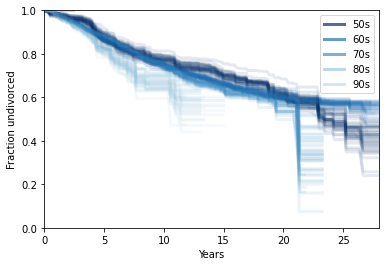

In [31]:
# here I am printing the functions above, which generates a graph
# of undivorced fraction during the decades (50 to 90's)

ResampleDivorceCurveByDecade([married6, married7])